## Importing Modules

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel, DataCollatorWithPadding, AdamW
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from math import sqrt
import re
import numpy as np
tqdm.pandas()

## Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Selecting rows with 'salary' and 'description' and removing columns that are not necessary

In [3]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    data = data.dropna(axis=0, subset='normalized_salary')
    data = data.dropna(axis=0, subset='description')
    data = data[data['pay_period']=='YEARLY']
    data = data[data['currency']=='USD']
    data.drop(['job_posting_url','original_listed_time',
              'compensation_type', 'company_id',
              'closed_time','remote_allowed','applies',
              'posting_domain','application_url',
              'fips','zip_code','min_salary','med_salary','max_salary',
              'formatted_work_type','views','job_id','expiry',
              'sponsored','listed_time','pay_period','currency','application_type'],axis=1,inplace=True)
    data = data[data['normalized_salary']>10000]
    return data

## Loading the data

In [5]:
file_loc = '/content/drive/MyDrive/Linkedin Job Posting Dataset/postings.csv'
df=load_data(file_loc)

## Some basic data insights

In [6]:
df.isna().sum()

,0
company_name,292
title,0
description,0
location,0
formatted_experience_level,4949
skills_desc,20056
work_type,0
normalized_salary,0


In [7]:
# removing info 'descriptions' columns having length less than 100 as they contain no info
df = df[
    df["description"].apply(lambda x: len(x) > 100)
]

## Conactenating columns

In [8]:
# Concatenating columns to make a single 'info' column
df.replace(np.nan, '', regex=True, inplace=True)
df_f = pd.DataFrame()
df_f['info'] = (
    df['company_name'] + ' ' +
    df['title'] + ' ' +
    df['formatted_experience_level'] + ' ' +
    df['work_type'] + ' ' +
    df['location'] + ' ' +
    df['skills_desc'] + ' ' +
    df['description']
)
df_f['normalized_salary'] = df['normalized_salary'].astype(int)

## Cleaning the 'info' column

In [10]:
# cleaning
def clean_text(text):
    # Lower
    text = text.lower()

    # Spacing and filters
    # text = re.sub(r'\([^)]*\)', '', text) # removing texts inside '(' and ')'
    # text = re.sub(r'\d+', '', text) # removing digits (may change later)
    text = re.sub(r'\*+', '', text)
    text = re.sub(r"http\S+", "", text) # removing websites
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '', text)
    text = re.sub(r'\b\S+?@\S+?\.\S+?\b', '', text) # removing email address
    text = re.sub(r'\\n|\n',' ',text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white spaces

    return text

In [11]:
df_f['info'] = df_f['info'].progress_apply(clean_text)

100%|██████████| 20193/20193 [00:24<00:00, 825.87it/s]


In [12]:
df_f['normalized_salary'].min(), df_f['normalized_salary'].max()

(10500, 102500000)

In [13]:
Q1 = df_f['normalized_salary'].quantile(0.25)
Q3 = df_f['normalized_salary'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range
filter = (df_f['normalized_salary'] >= Q1 - 1.5 * IQR) & (df_f['normalized_salary'] <= Q3 + 1.5 *IQR)
df_f = df_f[filter]

In [14]:
df_f['normalized_salary'].min(), df_f['normalized_salary'].max()

(10500, 245500)

<Axes: ylabel='Frequency'>

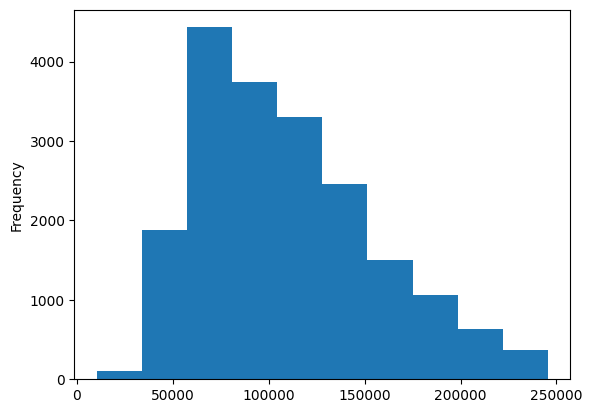

In [15]:
df_f['normalized_salary'].plot(kind='hist')

In [16]:
print(df_f.shape)
df_f.to_csv('df_f.csv', index=False)

(19479, 2)


## Load and tokenize data


In [18]:
def load_data_clean(file_loc):
    data = pd.read_csv(file_loc)
    return data

def preprocess_data(texts, labels, tokenizer, max_len):
    """Tokenizes text data using a tokenizer."""
    inputs = tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    return inputs, torch.tensor(labels)

## Dataclass for handling text and labels

In [19]:
class TextDataset(Dataset):
    """Custom Dataset class for loading tokenized text and labels."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

## Prepare dataloaders with train, val, and test splits

In [20]:
def prepare_dataloaders(data, tokenizer, max_len, train_batch_size,
                        val_batch_size, test_batch_size,
                        test_size=0.2, val_size=0.1, seed=42):
    # Split data with fixed random_state for reproducibility
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=seed)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=seed)

    # Apply log transformation
    train_data['normalized_salary'] = np.log1p(train_data['normalized_salary'])
    val_data['normalized_salary'] = np.log1p(val_data['normalized_salary'])
    test_data['normalized_salary'] = np.log1p(test_data['normalized_salary'])

    # Tokenize data
    train_inputs, train_labels = preprocess_data(train_data["info"].tolist(), train_data["normalized_salary"].tolist(), tokenizer, max_len)
    val_inputs, val_labels = preprocess_data(val_data["info"].tolist(), val_data["normalized_salary"].tolist(), tokenizer, max_len)
    test_inputs, test_labels = preprocess_data(test_data["info"].tolist(), test_data["normalized_salary"].tolist(), tokenizer, max_len)

    # Create datasets
    train_dataset = TextDataset(train_inputs, train_labels)
    val_dataset = TextDataset(val_inputs, val_labels)
    test_dataset = TextDataset(test_inputs, test_labels)

    # Data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=data_collator)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, collate_fn=data_collator)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=data_collator)

    return train_loader, val_loader, test_loader

## Define the model for regression

In [21]:
class BERTRegression(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(BERTRegression, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.pooler_output
        return self.regressor(last_hidden_state)

## Training function

In [22]:
def train_model(model, train_loader, val_loader, epochs, learning_rate,criterion, save_path, device):
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Validation loss improved to {best_val_loss:.6f}. Saving model...")
            torch.save(model.state_dict(), save_path)  # Save the model state_dict

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

## Evaluate on validation

In [23]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            outputs_exp = torch.expm1(outputs)
            labels_exp = torch.expm1(labels)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

## Test on test

In [24]:
def test_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    predictions = np.expm1(predictions)
    actuals = np.expm1(actuals)

    rmse = sqrt(mean_squared_error(actuals, predictions))
    print(f"Test RMSE: {rmse:.6f}")

    return predictions, actuals

## Main function

In [25]:
def set_seeds(seed: int = 42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# def main():
set_seeds(42)  # Set seeds for reproducibility

filepath = '/content/df_f.csv'
model_name = 'bert-base-uncased'
max_len = 512
train_batch_size = 16
val_batch_size = 32
test_batch_size = 32
epochs = 6
learning_rate = 0.5e-5
criterion = nn.HuberLoss(delta=1.0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = '/content/bert_final.pth'

# Load data
data = load_data_clean(filepath)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Prepare dataloaders
train_loader, val_loader, test_loader = prepare_dataloaders(data, tokenizer, max_len,
                                                            train_batch_size, val_batch_size,
                                                            test_batch_size, seed=42)

# Initialize and train model
model = BERTRegression(model_name).to(device)
train_model(model, train_loader, val_loader, epochs, learning_rate, criterion, save_path, device)

# Evaluate on test dataset
# pred,act = test_model(model, test_loader, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Loading model for prediction on test

In [26]:
def load_model(model_class, model_name, save_path, device):
    # Recreate the model
    model = model_class(model_name)
    # Load the saved state dict into the model, mapping the model to the correct device
    model.load_state_dict(torch.load(save_path, map_location=device))
    # Explicitly move the model to the desired device
    model.to(device)  # Add this line
    model.eval()  # Set model to evaluation mode
    return model

# Load the saved model for inference
loaded_model = load_model(BERTRegression, "bert-base-uncased", "/content/bert_final.pth", device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-26-1c521e05f908>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=device))


## Prediction on test

In [27]:
# latest
pred1, act1 = test_model(loaded_model, test_loader, device)

<ipython-input-19-6d815abda472>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-6d815abda472>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)


Test RMSE: 28541.888935


## R2 score

In [28]:
# R2 score
from sklearn.metrics import r2_score
r2_score(act1, pred1)

0.6040883660316467

## Plotting the predictions vs actuals

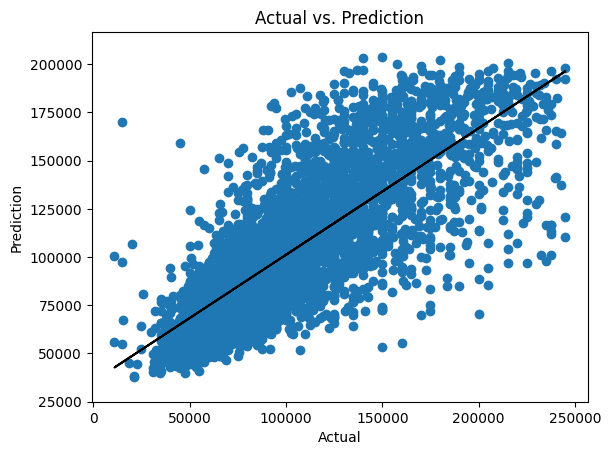

In [ ]:
# latest
from matplotlib import pyplot as plt

results = pd.DataFrame({
    "Actual": act1,
    "Prediction": pred1
})
coef = np.polyfit(results['Actual'],results['Prediction'], deg=1)
poly1d_fn = np.poly1d(coef)


plt.scatter(results['Actual'],results['Prediction'])
plt.plot(results['Actual'], poly1d_fn(results['Actual']),color='black')
plt.axis('equal')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction')
plt.show()

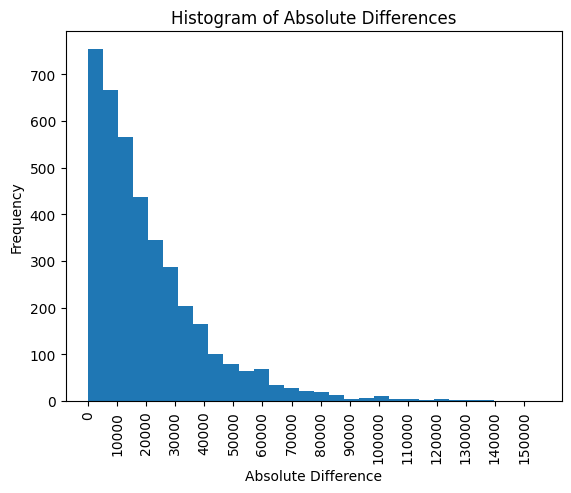

In [ ]:
import matplotlib.pyplot as plt

results['diff'] = results['Prediction'] - results['Actual']
results['abs_diff'] = abs(results['Prediction'] - results['Actual'])

# Plot the histogram
ax = results['abs_diff'].plot(kind='hist', bins=30)  # Adjust 'bins' as needed

# Set custom x-axis ticks
ticks = range(0, int(results['abs_diff'].max()) + 10, 10000)  # Adjust step as needed
plt.xticks(ticks)
plt.xticks(rotation=90)
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Absolute Differences')

plt.show()

## Correlation between actuals and predictions

In [ ]:
results['Actual'].corr(results['Prediction'])

0.7805915841917697

## Some more analysis

In [ ]:
results[results['abs_diff']<15000]['abs_diff'].shape[0]/results.shape[0]

0.49460985626283366

49.46% of actual salaries are having predictions + or - 15,000 deviations

In [ ]:
results[results['abs_diff']<20000]['abs_diff'].shape[0]/results.shape[0]

0.6078028747433265

60% of actual salaries are having predictions + or - 20,000 deviations

<Axes: ylabel='Frequency'>

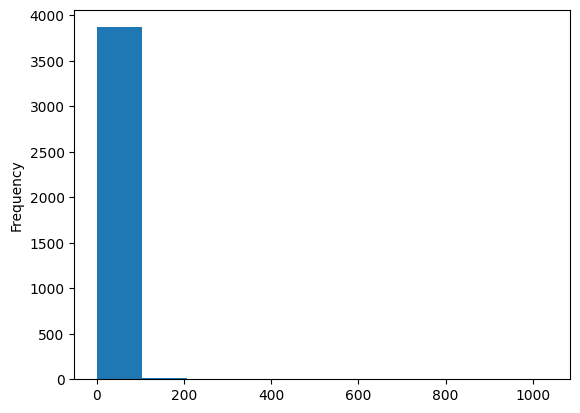

In [ ]:
results['percentage_var'] = results['abs_diff']/results['Actual']*100

results['percentage_var'].plot(kind='hist', bins=10)

In [ ]:
results[results['percentage_var']<30]['percentage_var'].shape[0]/results.shape[0]

0.7867043121149897

78% of test actuals having predicted + or - 30 percentage deviated